# Wind storm workflow (now only raster based, single event)

TODO: update towards vector and multi event sets

load packages


In [1]:
import os
import pooch

import rasterio
from pathlib import Path
import rioxarray as rxr
import xarray as xr

from damagescanner.core import RasterScanner
from damagescanner.plot import damagemap_raster

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

# added later
import cdsapi
from zipfile import ZipFile
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
import numpy as np
import matplotlib
import damagescanner
import osmnx as ox

import geopandas as gpd
from shapely.geometry import Polygon

## Load in data

In [2]:
dir =  ""
workflow_folder = os.path.join(dir, '')
data_dir = os.path.join(workflow_folder,'data')


### Load in windmaps

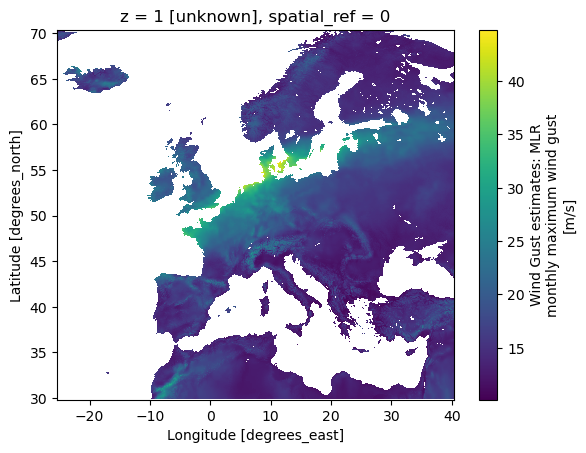

In [3]:
with ZipFile(f"{data_dir}/Carmen.zip") as zf:
    
    # Let's get the filename first
    file = zf.namelist()[0]
    
    # And now we can open and select the file within Python
    with zf.open(file) as f:
        windstorm_europe = xr.open_dataset(f)

windstorm_europe = windstorm_europe.rename({'Latitude': 'y','Longitude': 'x'})
windstorm_europe = windstorm_europe.rio.set_spatial_dims(x_dim="x",y_dim="y", inplace=True)

windstorm_europe.rio.write_crs(4326, inplace=True)

windstorm_europe = windstorm_europe['FX'][0]

#plot
windstorm_europe.plot()

### set to region specific

create bounding box. See https://boundingbox.klokantech.com/ to get the bounding box of your area of interest (select csv in the copy-paste field at the bottom of the website window)


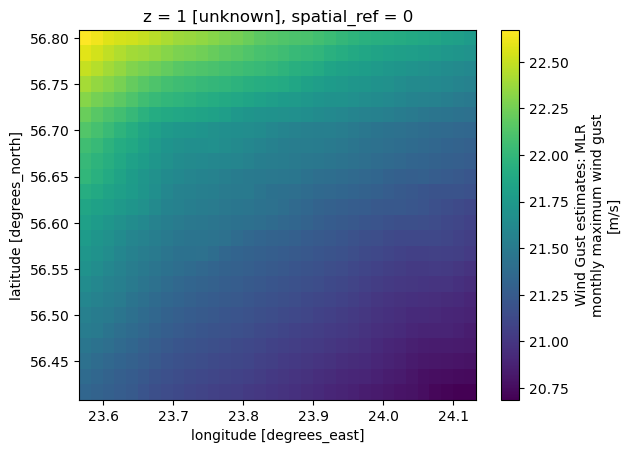

In [4]:
bbox = [23.5792,56.416,24.1312,56.8018] # [lon_min, lat_min, lon_max, lat_max]

windstorm_region = windstorm_europe.rio.clip_box(*bbox, 
                                                 crs=4326)


windstorm_region.plot()

## Load in land use data and set to region

In [5]:
filename_land_use = f'{data_dir}/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif'
land_use = rxr.open_rasterio(filename_land_use)
land_use.rio.write_crs(3035, inplace=True)

# clip land use to the same extent as the windstorm
land_use_region = land_use.rio.clip_box(*bbox,
                                        crs="EPSG:4326")

land_use_region = land_use_region.rio.reproject("EPSG:4326")

# convert minus values to nan
land_use_region = land_use_region.where(land_use_region > 0)

In [6]:
# set windstorm_region interpolated to land_use_region
windstorm_region = windstorm_region.rio.reproject_match(land_use_region)

windstorm_region = windstorm_region.assign_coords({
    "x": land_use_region.x,
    "y": land_use_region.y,
})

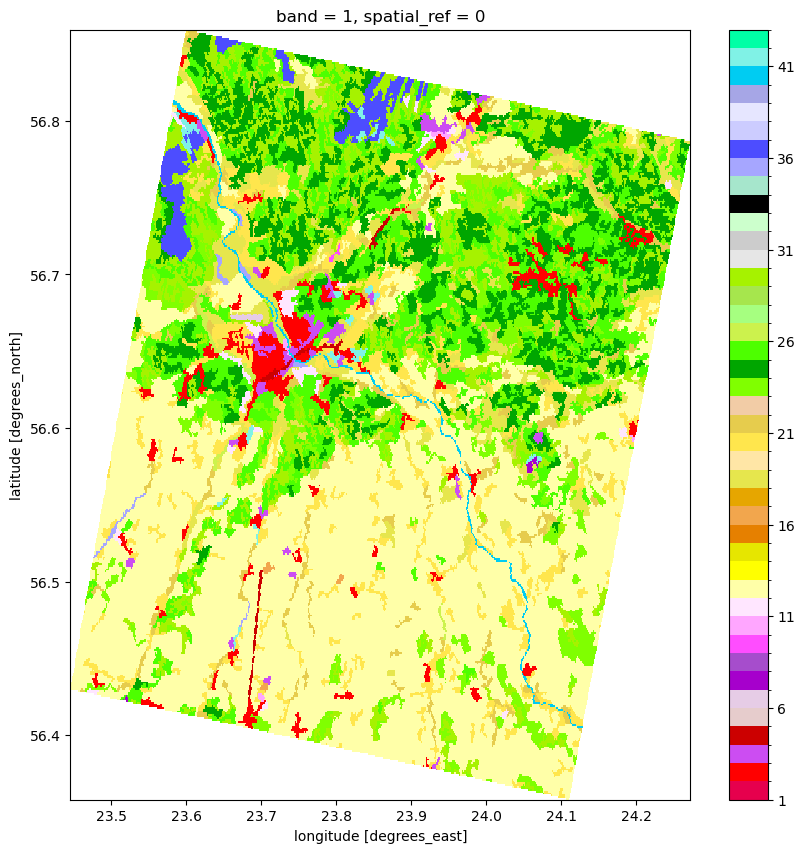

In [7]:
CLC_values = np.arange(1,44)

CLC_colors = ['#E6004D', '#FF0000', '#CC4DF2', '#CC0000', '#E6CCCC', '#E6CCE6', '#A600CC', '#A64DCC', '#FF4DFF', '#FFA6FF', '#FFE6FF', '#FFFFA8', '#FFFF00', '#E6E600',
 '#E68000', '#F2A64D', '#E6A600', '#E6E64D', '#FFE6A6', '#FFE64D', '#E6CC4D', '#F2CCA6', '#80FF00', '#00A600',
 '#4DFF00', '#CCF24D', '#A6FF80', '#A6E64D', '#A6F200', '#E6E6E6', '#CCCCCC', '#CCFFCC', '#000000', '#A6E6CC',
 '#A6A6FF', '#4D4DFF', '#CCCCFF', '#E6E6FF', '#A6A6E6', '#00CCF2', '#80F2E6', '#00FFA6', '#A6FFE6', '#E6F2FF']


# plot the land use
land_use_region.plot(levels=CLC_values, colors=CLC_colors, figsize=(10,10))

### match both data sets and prepare for DamageScanner

In [8]:
land_use_region = land_use_region.where(windstorm_region.notnull())
windstorm_region = windstorm_region.where(land_use_region.notnull())


In [9]:
# land_use_region = land_use_region.sel(band=1, z=1)
# windstorm_region = windstorm_region.sel(z=1, band=1)

Text(0.5, 1.0, 'Windstorm Carmen 2018 and land use 2020')

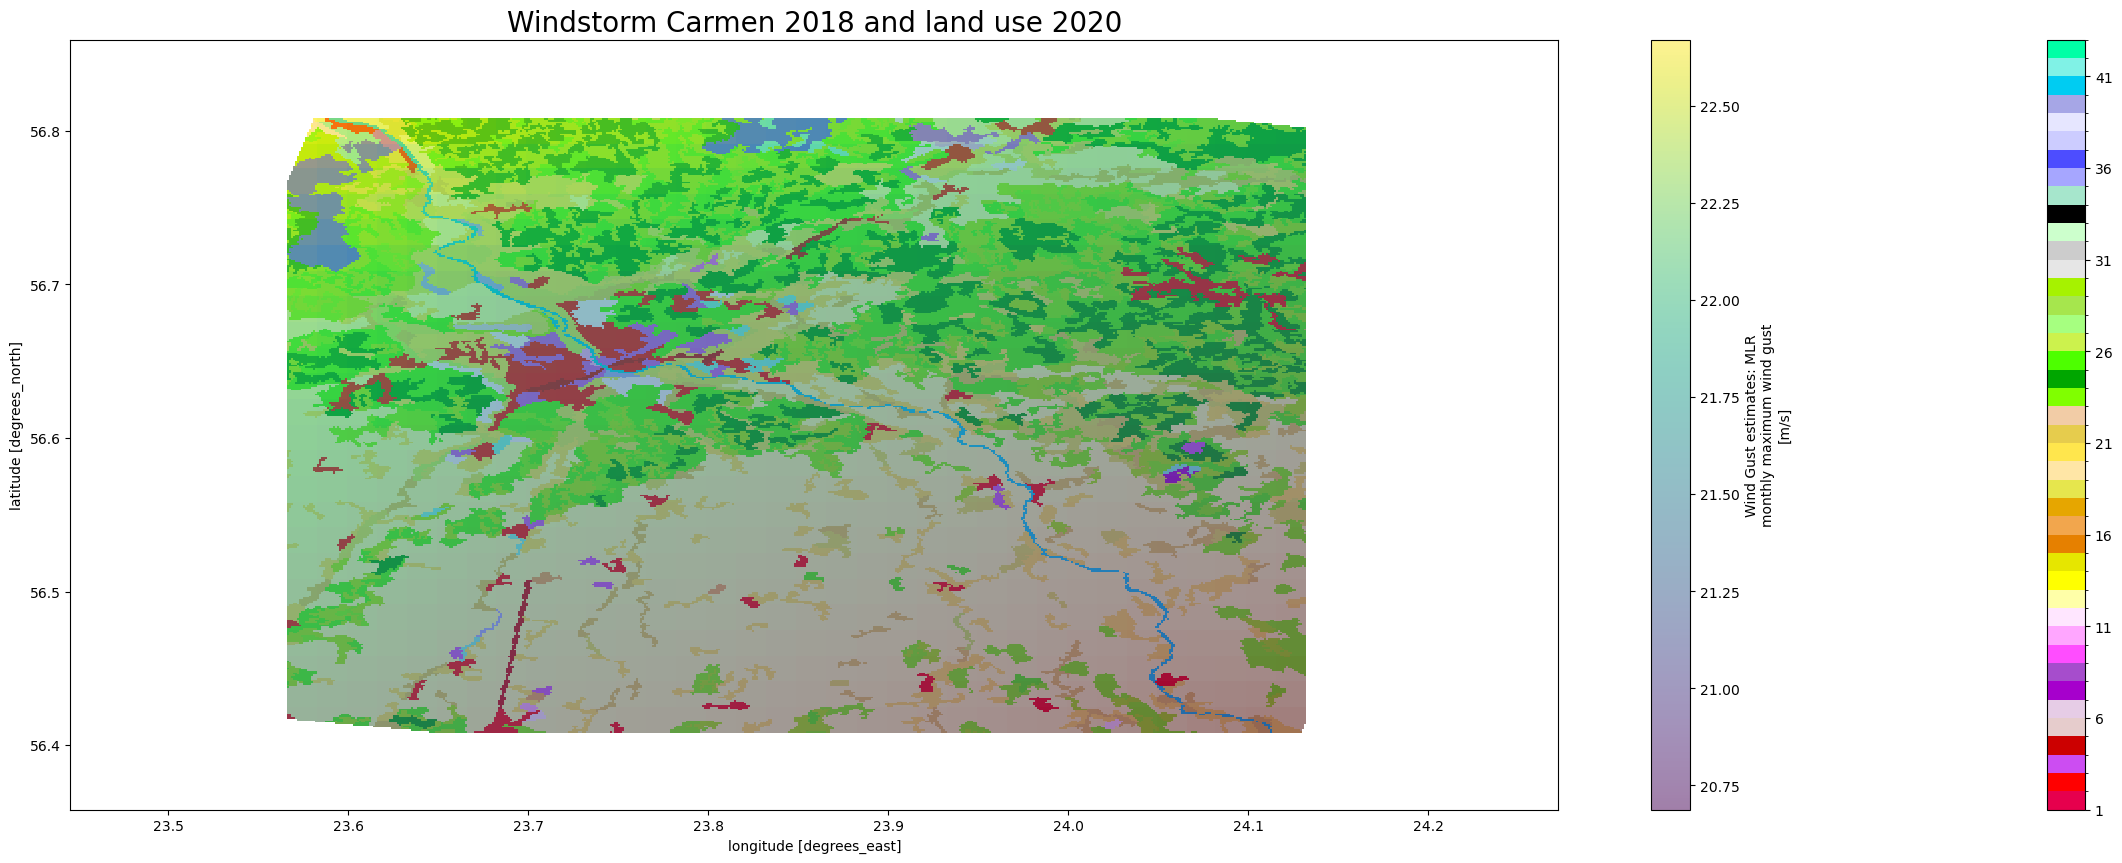

In [10]:
# plot
fig, ax = plt.subplots(figsize=(30, 10))
land_use_region.plot(ax=ax, levels=CLC_values, colors=CLC_colors, alpha=1)
windstorm_region.plot(ax=ax, cmap='viridis', alpha=0.5)
ax.set_title('Windstorm Carmen 2018 and land use 2020', fontsize=20)

In [11]:
# reproject to 3857 for the damage scanner
windstorm_region=windstorm_region.transpose('band', 'y', 'x')
windstorm_region = windstorm_region.rio.reproject(3857)
windstorm_region = windstorm_region

land_use_region=land_use_region.transpose('band', 'y', 'x')
land_use_region = land_use_region.rio.reproject(3857)
land_use_region = land_use_region

# convert to Latitude and Longitude from x and y and 
# windstorm_region = windstorm_region.rename({'x': 'Latitude', 'y': 'Longitude'})
# land_use_region = land_use_region.rename({'x': 'Latitude', 'y': 'Longitude'})

### testing purpose!!

In [12]:
# set all values to a random number from 
damage_curve_classes = [110,111,112,120,130,131,132,133,134,135,136,140,141,142,143,144,150,151,152,210,211,220,221,230,240,250,310,320,330,340,350,360,370,380,410,420,430,440,450,460,470,510,520,530,540,550,560,610,620,630,640,650]

# assign values in land use region to damage curve classes map 1=110, 2=111, 3=112, etc
damage_curve_classes_map = land_use_region

i=0
for land_use_value in range(1, 44):
    damage_curve_classes_map = xr.where(land_use_region == land_use_value, int(damage_curve_classes[i]), damage_curve_classes_map)
    i+=1 


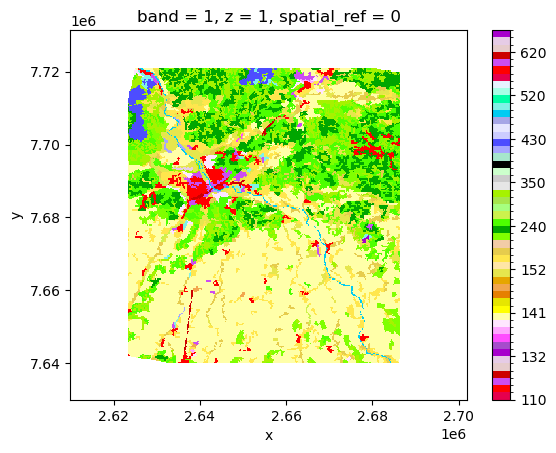

In [13]:
damage_curve_classes_map.plot(colors=CLC_colors, levels=damage_curve_classes)

## save maps to serve as inputs for DamageScanner

In [14]:
# save both maps as nc
# land_use_region.to_netcdf(f'{data_dir}/LUISA_LU/2030_LUISA_LU_region.nc')
# windstorm_region.to_netcdf(f'{data_dir}/Carmen_region.nc')

# save to tiff

# land_use_region.rio.to_raster(f'{data_dir}/LUISA_LU/2030_LUISA_LU_region.tiff')
# windstorm_region.rio.to_raster(f'{data_dir}/Carmen_region.tiff')


In [15]:
windstorm_region = windstorm_region[0]
damage_curve_classes_map = damage_curve_classes_map[0]

## Run damage scanner

In [16]:
curve_path = os.path.join(data_dir,'curves.csv')
maxdam_path = os.path.join(data_dir,'maxdam.csv')

damage_catagory, damage_map, _, _ = RasterScanner(   damage_curve_classes_map,
                                        windstorm_region,
                                        curve_path,
                                        maxdam_path,
                                        scenario_name='Carmen',
                                        lu_crs=damage_curve_classes_map.rio.crs, # 4326
                                        haz_crs=windstorm_region.rio.crs, # 4326                   
                                        dtype = np.int64, # if set to int32 it gives an error
                                        save=False)

## Check results

In [17]:
damage_catagory

,damages
landuse,
110,0
111,152798692173
112,31394739893
120,286901002
130,0
131,3305338631
132,1150592561
133,0
134,1464390532


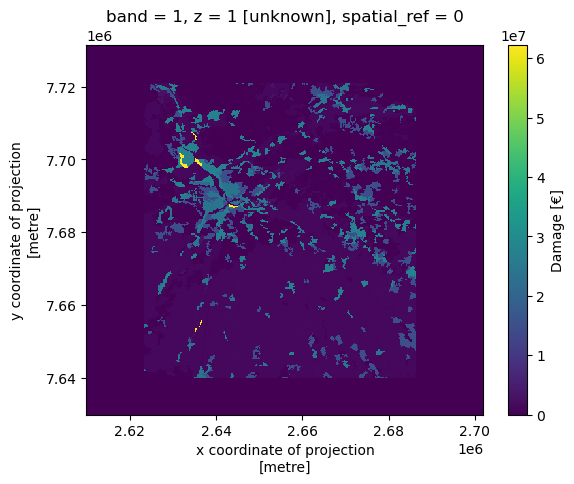

In [18]:
damage_map.plot()